# Training One-class Autoencoder for NSL-KDD Classificiation

## Import required packages

In [1]:
import os
import itertools

import numpy as np
import pandas as pd
import h5py

from keras.layers import Input, Dense, LeakyReLU, Dropout
from keras.models import Model, load_model
from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

Using TensorFlow backend.


## Dataset import function

In [2]:
def get_dataset(dirname=os.path.join('..', 'hdf5'), filename=None, tagname=None):
    if filename is None or tagname is None:
        raise ValueError('File name and tag name should be set.')
    with h5py.File(os.path.join(dirname, filename), 'r') as hdf:
        return hdf[tagname][:]

## Autoencoder intialization function

In [3]:
def get_autoencoder(loss_func):    
    # input layer
    inp = Input(shape=(114,)) # layer 1
    
    # encoding layers
    enc = Dense(512)(inp) # layer 2
    enc = Dropout(0.5)(enc)
    enc = LeakyReLU(0.01)(enc)
    enc = Dense(256)(enc) # layer 3
    enc = Dropout(0.5)(enc)
    enc = LeakyReLU(0.01)(enc)
    enc = Dense(128)(enc) # layer 4
    enc = Dropout(0.5)(enc)
    enc = LeakyReLU(0.01)(enc)
    
    # bottleneck layer
    mid = Dense(64)(enc) # layer 5
    mid = Dropout(0.5)(mid)
    mid = LeakyReLU(0.01)(mid)
    
    # decoding layers
    dec = Dense(128)(mid) # layer 6
    dec = Dropout(0.5)(dec)
    dec = LeakyReLU(0.01)(dec)
    dec = Dense(256)(dec) # layer 7
    dec = Dropout(0.5)(dec)
    dec = LeakyReLU(0.01)(dec)
    dec = Dense(512)(dec) # layer 8
    dec = Dropout(0.5)(dec)
    dec = LeakyReLU(0.01)(dec)
    
    # output layer
    out = Dense(114, activation='sigmoid')(dec)
    
    # create new model
    autoencoder = Model(inp, out)
    autoencoder.compile(loss=loss_func, optimizer='rmsprop')
    return autoencoder

## Model summary

In [4]:
get_autoencoder('categorical_crossentropy').summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 114)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               58880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0   

## Train function

In [5]:
def train_and_save(loss_func, train_type, filename):
    # get dataset
    if train_type == 'normal':
        x_train = get_dataset(filename='train_normal.hdf5', tagname='x')
    elif train_type == 'mix':
        x_train = get_dataset(filename='train_mix.hdf5', tagname='x')
    else:
        raise ValueError('Train type should be either normal or mix.')
    x_val = get_dataset(filename='test.hdf5', tagname='x')
    
    # autoencoder initialization
    autoencoder = get_autoencoder(loss_func)
    
    # set callbacks
    es = EarlyStopping(patience=3, monitor='val_loss')
    mc = ModelCheckpoint(os.path.join('save', filename), save_best_only=True)
    
    # train
    history = autoencoder.fit(x_train, x_train, validation_data=(x_val, x_val),
                    epochs=30, batch_size=64, callbacks=[es, mc])
    print('Best model saved to', os.path.join('save', filename), end='\n\n')
    
    return history

## List to try

In [6]:
loss_func_list = ['categorical_crossentropy', 'mean_absolute_error']
train_type_list = ['normal', 'mix']

## Start training

In [7]:
model_list = list()
history_list = list()
for loss_func, train_type in itertools.product(loss_func_list, train_type_list):
    model_list.append('_'.join([loss_func, train_type]) + '.h5')
    print('Training', model_list[-1], '...')
    history = train_and_save(loss_func, train_type, model_list[-1])
    history_list.append(history)

Training categorical_crossentropy_normal.h5 ...
Train on 67343 samples, validate on 22544 samples
Epoch 1/30
67343/67343 [==============================] - 31s 459us/step - loss: 14.1840 - val_loss: 17.9541
Epoch 2/30
67343/67343 [==============================] - 26s 391us/step - loss: 13.3632 - val_loss: 17.7539
Epoch 3/30
67343/67343 [==============================] - 28s 415us/step - loss: 13.2308 - val_loss: 17.4153
Epoch 4/30
67343/67343 [==============================] - 28s 423us/step - loss: 13.1847 - val_loss: 17.5445
Epoch 5/30
67343/67343 [==============================] - 28s 415us/step - loss: 13.1538 - val_loss: 17.2042
Epoch 6/30
67343/67343 [==============================] - 29s 427us/step - loss: 13.1289 - val_loss: 17.2611
Epoch 7/30
67343/67343 [==============================] - 28s 421us/step - loss: 13.1162 - val_loss: 17.0081
Epoch 8/30
67343/67343 [==============================] - 25s 378us/step - loss: 13.1046 - val_loss: 17.3160
Epoch 9/30
67343/67343 [======

## Loss graphs

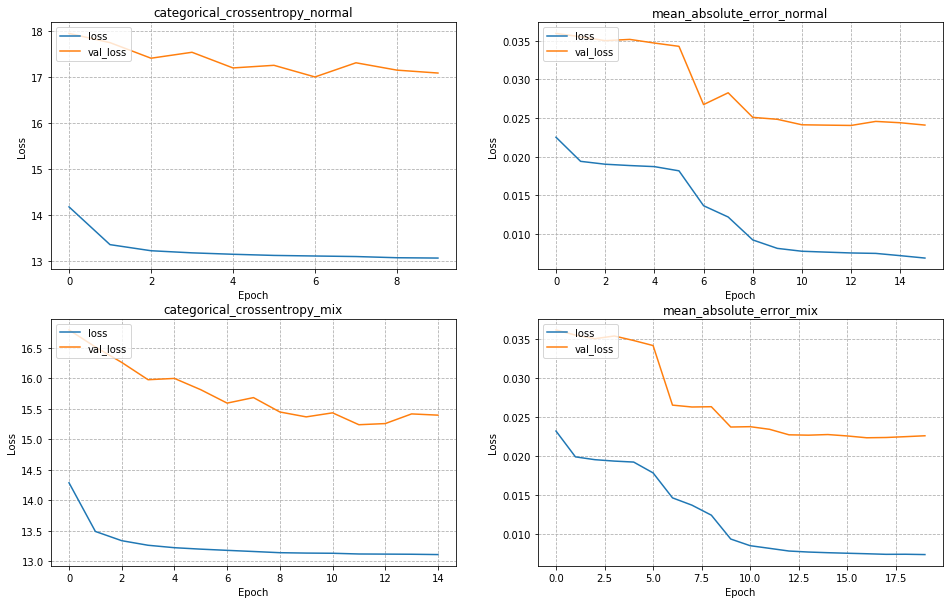

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
for i, h in enumerate(history_list):
    axx = ax[i%2][i//2]
    axx.grid(linestyle='--')
    axx.plot(h.history['loss'])
    axx.plot(h.history['val_loss'])
    axx.set_title(model_list[i][:-3])
    axx.legend(['loss', 'val_loss'], loc='upper left')
    axx.set_xlabel('Epoch')
    axx.set_ylabel('Loss')